In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from pdet import MZQbin, alphaBayesCI_map

In [35]:
# Pick higher masses for higher redshifts!

minf, msup = 8, 13
zw = 0.01 # Width of redshift bins
zref = 0.2 # Reference redshift (inferior limit of reference redshift bin)
q = 0.5 # # q = m2 / m1, with m2 <= m1

bin2_ref = MZQbin(minf, msup, zref, zref + zw, q)
N2_ref = 60

T_obs = 1

zinf_axis = np.arange(0, 0.45, zw) # Inferior limits of map's redshift bins
bins_axis = [MZQbin(minf, msup, zinf, zinf + zw, q) for zinf in zinf_axis]
R1_R2_axis = np.arange(0.1, 5, 0.1)

cl = 0.95

In [36]:
if __name__ == '__main__':
    alpha_CI_map = alphaBayesCI_map(cl, bin2_ref, R1_R2_axis, bins_axis, N2_ref, T_obs)

Computing the 95.0% confidence interval for each (R1_R2, bin_z) pair for a uniformly distributed population of sources with fixed q = 0.5:   0%|          | 0/2205 [00:00<?, ?it/s]/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio

In [37]:
with open('data/alpha_CI_map.pkl', 'wb') as file:
    pickle.dump(alpha_CI_map, file)

In [38]:
alpha_CI_array = np.zeros((len(R1_R2_axis), len(bins_axis), 3))
alpha_a_array = np.zeros((len(R1_R2_axis), len(bins_axis)))

N1_N2_ref = 2
Det_map = np.zeros((len(R1_R2_axis), len(bins_axis)))

for i, _ in enumerate(R1_R2_axis):
    for j, _ in enumerate(bins_axis):
        alpha_CI_array[i, j] = np.copy(alpha_CI_map[i][j][0])
        alpha_a_array[i, j] = alpha_CI_map[i][j][2] # a = bin2_ref.VT / bin.VT
        if alpha_CI_map[i][j][0][0] <= N1_N2_ref <= alpha_CI_map[i][j][0][2]:
            Det_map[i, j] = 1

In [39]:
print(np.min(alpha_CI_array[:, :, 1]), np.max(alpha_CI_array[:, :, 1]))
print(np.min(alpha_a_array), np.max(alpha_a_array))

0.0037827008739624722 6.786964637928063
0.7093158386830566 603070.1631264797


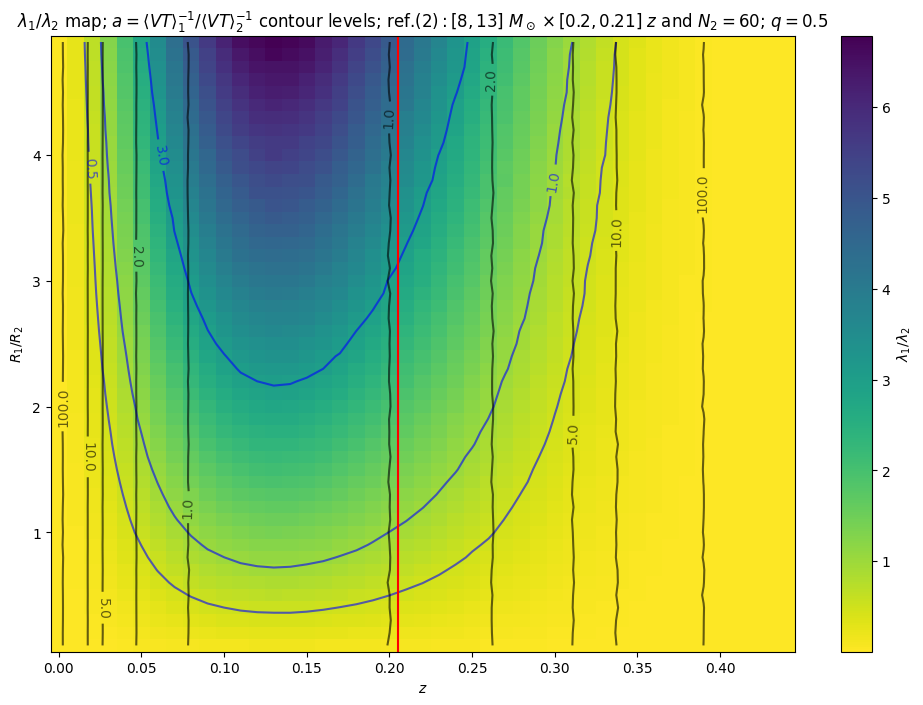

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$\lambda_1 / \lambda_2$ map; $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}}$ contour levels; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$'.format(bin2_ref.minf,
                                                                                                                                                                                                                     bin2_ref.msup,
                                                                                                                                                                                                                     bin2_ref.zinf,
                                                                                                                                                                                                                     np.format_float_positional(bin2_ref.zsup, 2),
                                                                                                                                                                                                                     N2_ref,
                                                                                                                                                                                                                     q))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$R_1 / R_2$')

# lambda_1 / lamba_2 color map and few contour levels
cmap = plt.colormaps['viridis_r']
im = ax.pcolormesh(zinf_axis, R1_R2_axis, alpha_CI_array[:, :, 1], cmap=cmap)
fig.colorbar(im, ax=ax, label=r'$\lambda_1 / \lambda_2$')
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_CI_array[:, :, 1],
                levels=[0.5, 1, 3], colors='blue', alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red')

plt.show()

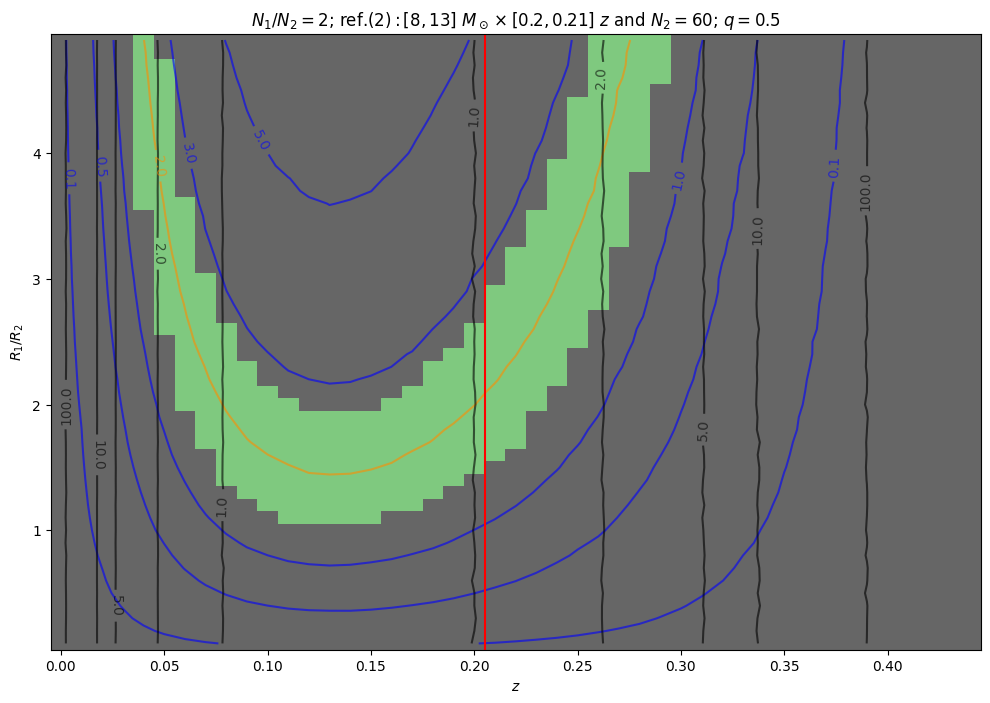

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$N_1 / N_2 = {5}$; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {6}$'.format(bin2_ref.minf,
                                                                                                                       bin2_ref.msup,
                                                                                                                       bin2_ref.zinf,
                                                                                                                       np.format_float_positional(bin2_ref.zsup, 2),
                                                                                                                       N2_ref,
                                                                                                                       N1_N2_ref,
                                                                                                                       q))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$R_1 / R_2$')

# lambda_1 / lamba_2 color map and few contour levels
cmap = plt.colormaps['Accent_r']
im = ax.pcolormesh(zinf_axis, R1_R2_axis, Det_map, cmap=cmap)
levels = list(dict.fromkeys(sorted([0.1, 0.5, 1, 3, 5, 10, N1_N2_ref]))) # To avoid duplicates
colors = ['blue'] * (len(levels))
colors[levels.index(N1_N2_ref)] = 'darkorange'
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_CI_array[:, :, 1],
                levels=levels, colors=colors, alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red')

plt.show()